# Coursework 3

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

In [1]:
import numpy
from scipy.integrate import quad
from matplotlib import pyplot

## Stochastic Differential Equations - Ornstein-Ühlenbeck problem

Consider the Ornstein-Uhlenbeck problem
$$
  \text{d}X = -\lambda X \, \text{d}t + \mu \, \text{d}W.
$$

Its solution is
$$
  X(t) = e^{-\lambda t} X_0 + \mu \int_0^t e^{-\lambda (t - s)} \, \text{d}W(s).
$$

In addition, we can calculate $\mathbb{E}(X)$ and $\mathbb{E}(X^2)$ as
$$
\begin{align}
  \mathbb{E}(X) & = e^{-\lambda t} X_0, \\
  \mathbb{E}(X^2) & = e^{-2\lambda t} X_0^2 + \frac{\mu^2}{2 \lambda} \left( 1 - e^{-2 \lambda t} \right).
\end{align}
$$
In particular we can show that
$$
  \lim_{t \to \infty} X \sim N \left( 0, \frac{\mu^2}{2 \lambda} \right):
$$
that is, for late enough time the solution follows a normal distribution.

### Tasks

1. Solve the Ornstein-Ühlenbeck problem using the Euler-Maruyama method. Use $X_0 = 1, \lambda=1, \mu=1$ and solve to end time $T=1$. Using $\delta t = 2^{- \left(4, \dots, 10\right)}$ check the weak order of convergence by looking at the error in $X^2$.
2. Plot a histogram of $X(10)$ for $10^5$ realizations with $\delta t = 2^{-7}$, using Euler-Maruyama. How is it distributed?
3. By computing the mean of $X^2(T)$ (which is the variance), check that 
$$
  X^{(h)}(T) \sim N \left( 0, \frac{\mu^2}{2 \lambda - \lambda^2 \, \delta t} \right)
$$
for $T=10$ (which is meant to represent "large" $T$).
4. Repeat these steps for the theta method
$$
  X_{n+1} = X_n - \lambda \, \delta t \, \theta X_{n+1} - \lambda \, \delta t \, (1 - \theta) X_n + \mu \, \text{d}W_n
$$
for $\theta=1/2$. Why is it different?

In [172]:
def x_exact(X0, t_range, l, u, dW):
    X = numpy.zeros_like(dW)
    dw0 = dW[0]
    for i, dw in enumerate(dW):
        X[i] = numpy.exp(-l * t_range[i]) * X0 + u / l * (dw - numpy.exp(-l * t_range[i]) * dw0)
        
    return X

In [ ]:
def f(t, dw, i, l):
    

In [144]:
def EM(X0, t_range, l, u, dW):
    X = numpy.zeros_like(dW)
    X[0] = X0
    dt = t_range[1] - t_range[0]
    W = numpy.zeros(dW.shape[0])
    
    for i, dw in enumerate(dW[:-1]):
        X[i+1] = X[i] - l * X[i] * dt * t_range[i] + u * dw
        W[i+1] = W[i] + dw
        
    return X, W

In [4]:
def init_vals():
    X0 = 1
    l = 1
    u = 1
    T = 1
    return X0, l, u, T

In [6]:
def EX2(X0, t_range, l, u, dW):
    E = numpy.zeros_like(dW)
    E = numpy.exp(-2 * l * t_range) * X0 * X0 + u * u / (2 * l) * (1 - numpy.exp(-2 * l * t_range))
    return E

In [7]:
def weak(n, m):
    X0, l, u, T = init_vals()
    N = 2**n
    dt = T/N
    DT = numpy.sqrt(dt)
    t_range = numpy.linspace(dt, T, N)
    E_n = 0
    E_e = 0
    for i in range(m):
        dW = numpy.random.randn(N) * DT

        X, W = EM(X0, t_range, l, u, dW)
        x_e = x_exact(X0, t_range, l, u, dW)
        E_n += abs(X[-1])
        E_e += abs(x_e[-1])
    
    E = abs(E_e - E_n) / m
    return E

In [8]:
def plot_conver(Ninit, Nfinal, m):
    n = Nfinal - Ninit + 1
    E = numpy.zeros(n)
    h = numpy.zeros(n)
    for i in range(n):
        E[i] = weak(i + Ninit, m)
        h[i] = 1/2**(i + Ninit)
        print(i)
    return E, h

In [171]:
E, h = plot_conver(4, 10, 500)
print(E, h)

0
1
2
3
4
5
6
[ 0.38671385  0.4059906   0.40817472  0.39517312  0.41324051  0.40316802
  0.40142717] [ 0.0625      0.03125     0.015625    0.0078125   0.00390625  0.00195312
  0.00097656]


In [ ]:

grad, e_pow = numpy.polyfit(numpy.log(h), numpy.log(E), 1)
conv = numpy.exp(e_pow) * h**grad
print(grad, conv)

-0.164305295904 [ 0.00525293  0.00588657  0.00659665  0.00739238  0.00828409  0.00928337
  0.01040319]


In [ ]:
pyplot.loglog(h, E, 'kx')

In [9]:
x_exact(1, t_range, 1, 1, dW)**2

NameError: name 't_range' is not defined

In [179]:
X0, l, u, T = init_vals()
N = 2**10
dt = T/N
DT = numpy.sqrt(dt)
t_range = numpy.linspace(dt, T, N)
dW = numpy.random.randn(N) * DT
dW
EM(X0, t_range, l, u, dW)[0][-1]**2

6.1921154104221401

In [180]:
x_exact(X0, t_range, l, u, dW)[-1]**2

0.14150582126056563

In [143]:
EX2(X0, t_range, l, u, dW)[-1]

0.56766764161830641

## Self consistent fields - Water

Perform the self-consistent field calculation for a water molecule, $\text{H}_2\text{O}$.

### Parameters

The locations of the atoms are:

In [2]:
R_O = [0.0, 1.809*numpy.cos(104.52/180.0*numpy.pi/2.0), 0.0]
R_H1 = [-1.809*numpy.sin(104.52/180.0*numpy.pi/2.0), 0.0, 0.0]
R_H2 = [+1.809*numpy.sin(104.52/180.0*numpy.pi/2.0), 0.0, 0.0]

The nuclear repulsion energy is:

In [3]:
Vnn = 8.90770810

The overlap matrix is:

In [4]:
S = numpy.array([[ 1.       ,  0.2367039,  0.       ,  0.       , -0.       ,
         0.0500137,  0.0500137],
       [ 0.2367039,  1.       ,  0.       ,  0.       , -0.       ,
         0.4539953,  0.4539953],
       [ 0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
         0.2927386, -0.2927386],
       [-0.       , -0.       ,  0.       ,  0.       ,  1.       ,
         0.2455507,  0.2455507],
       [ 0.0500137,  0.4539953,  0.       ,  0.2927386,  0.2455507,
         1.       ,  0.2510021],
       [ 0.0500137,  0.4539953,  0.       , -0.2927386,  0.2455507,
         0.2510021,  1.       ]])

The core Hamiltonian is:

In [5]:
H = numpy.array([[ -3.26850823e+01,  -7.60432270e+00,   0.00000000e+00,
          0.00000000e+00,  -1.86797000e-02,  -1.61960350e+00,
         -1.61960350e+00],
       [ -7.60432270e+00,  -9.30206280e+00,   0.00000000e+00,
          0.00000000e+00,  -2.22159800e-01,  -3.54321070e+00,
         -3.54321070e+00],
       [  0.00000000e+00,   0.00000000e+00,  -7.43083560e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -7.56702220e+00,   0.00000000e+00,  -1.89085610e+00,
          1.89085610e+00],
       [ -1.86797000e-02,  -2.22159800e-01,   0.00000000e+00,
          0.00000000e+00,  -7.52665570e+00,  -1.65878930e+00,
         -1.65878930e+00],
       [ -1.61960350e+00,  -3.54321070e+00,   0.00000000e+00,
         -1.89085610e+00,  -1.65878930e+00,  -4.95649010e+00,
         -1.56026360e+00],
       [ -1.61960350e+00,  -3.54321070e+00,   0.00000000e+00,
          1.89085610e+00,  -1.65878930e+00,  -1.56026360e+00,
         -4.95649010e+00]])

The number of electrons is:

In [6]:
Nelectrons = 10

The two electron integrals are given in the data file:

In [7]:
G=numpy.fromfile('./H2O-two-electron.dat')
G = numpy.reshape(G,(7,7,7,7));

### Plotting

There is useful information contained in the basis functions. The calculations here used the *STO-3G* basis, which are Gaussians with carefully chosen coefficients. There is one basis function per atomic orbital: so one for each hydrogen (the "1s" orbital) and five for the oxygen (one for the "1s" orbital, one for the "2s" orbital, and three for the "2p" orbitals - one for each Cartesian direction, associated with the quantum spins). Each basis function is written
$$
  \tilde{\chi} (r) = \sum_{i=1}^3 c_{i} \left( \frac{2 \alpha_i}{\pi} \right)^{3/4} e^{-\alpha_i r^2},
$$
where $r$ is the distance to the nucleus of this particular atom, and the $c_i, \alpha_i$ coefficients depend on the atom and the orbital.

For the "1s" orbitals the values of the coefficients are
$$
\begin{align}
  c_1 &= 0.444635, & c_2 &= 0.535328, & c_3 &= 0.154329, \\
  \alpha_1 &= 0.109818 \zeta_1^2, & \alpha_2 &= 0.405771 \zeta_1^2, & \alpha_3 &= 2.22766 \zeta_1^2.
\end{align}
$$
Here $\zeta_1 = 1.24$ for hydrogen and $\zeta_1 = 7.66$ for oxygen.

For the "2s" orbital the coefficients are
$$
\begin{align}
  c_1 &= 0.700115, & c_2 &= 0.399513, & c_3 &= -0.0999672, \\
  \alpha_1 &= 0.0751386 \zeta_2^2, & \alpha_2 &= 0.231031 \zeta_2^2, & \alpha_3 &= 0.994203 \zeta_2^2.
\end{align}
$$
Here $\zeta_2 = 2.25$ for oxygen.

Finally, for the "2p" orbital, the coefficients are
$$
\begin{align}
  c_1 &= 0.391957, & c_2 &= 0.607684, & c_3 &= 0.1559163, \\
  \alpha_1 &= 0.0751386 \zeta_2^2, & \alpha_2 &= 0.231031 \zeta_2^2, & \alpha_3 &= 0.994203 \zeta_2^2.
\end{align}
$$

In the above matrices, the seven entries correspond to:
$$
\begin{align}
  0 &: \text{Oxygen, 1s}, \\
  1 &: \text{Oxygen, 2s}, \\
  2 &: \text{Oxygen, 2p (x)}, \\
  3 &: \text{Oxygen, 2p (y)}, \\
  4 &: \text{Oxygen, 2p (z)}, \\
  5 &: \text{Hydrogen (1), 1s}, \\
  6 &: \text{Hydrogen (2), 1s}.
\end{align}
$$

### Constructing the full molecular orbitals

Given these basis functions, the single orbital molecular orbitals can be constructed as
$$
  \chi_i = \sum_{\mu=1}^K C_{i\mu} \tilde{\chi}_{\mu}.
$$
The iso-surfaces of the molecular orbitals give useful information about the reaction properties of the molecule.

### Tasks

1. Compute the total energy using the self-consistent field method. Ensure that your code prints the energy to the screen and returns the basis coefficients $C$ for later use.
2. Construct the molecular orbitals and plot isocontours of each in the $x-y$ plane.

In [151]:
def transf_matrix(S):
    """
    Function that computes the transformation matrix X, given S the overlap matrix between the basis functions.
    
    Paramteres:
    S - numpy array  (N, N)
        the overlap matrix between the basis functions
        
    Returns
    X - numpy array (N, N)
        the transformation matrix
    """
    assert type(S) == numpy.ndarray, \
        "S is not a numpy array in transf_matrix. It is currently a {}.".format(type(S))
    assert S.shape[0] == S.shape[1], \
        "S must be a square matrix in transf_matrix. It's current shape is {}.".format(S.shape)
    Delta, U = numpy.linalg.eig(S)
    Delta = numpy.diag(Delta**(-1/2))
    X = numpy.dot(U, numpy.dot(Delta, numpy.conj(U).T))
    assert (X.shape == S.shape).all(), \
        "X is not the same shape as S in transf_matrix. It's current shape is {}.".format(X.shape)
    return X

In [152]:
def density_matrix(C, N):
    """Function that computes the density matrix D, given the number of electrons and the 
    basis coefficients as a matrix C.
    
    Paramters
    C - numpy array (n, n)
        matrix containing the coefficients of the basis faunctions
        
    N - int
        number of electrons in the molecule
        
    Return 
    D - numpy array (n, n)
        matrix containing the density matrix in the field"""
    
    assert type(C) == numpy.ndarray, \
        "C is not a numpy array. It currently is {}.".format(type(C))
    assert C.shape[0] == C.shape[1], \
        "C is not a square matrix. It's currently shape is {}.".format(C.shape)
    assert type(N) == int or type(N) == numpy.int, \
        "N is not an integer. It currently is {}.".format(type(N))

    N_e = int(numpy.around(N/2+0.49))
    uv, n = C.shape
    D = numpy.zeros([uv, uv])
    for u in range(uv):
        for v in range(uv):
            for j in range(N_e):
                D[u, v] += 2 * C[u, j] * C[v, j]
    assert D.shape == C.shape, \
        "D was not properly created. It's current shape is {}.".format(D.shape)
    return D


In [10]:
def fock_matrix(H, G, D):
    miu, niu = H.shape
    alpha, beta = D.shape
    F = numpy.zeros_like(H)
    
    for u in range(miu):
        for v in range(niu):
            F[u, v] = numpy.sum((G[u, v, :, :] - G[u, :, :, v].T * 0.5) * D)
    F += H
    return F

In [11]:
def orb_energya(F, X):
    ener, V = numpy.linalg.eigh(F)
    F_p = numpy.dot(numpy.conj(X).T, numpy.dot(F, X))  
    epsilon, V = numpy.linalg.eigh(F_p)
    return epsilon, numpy.dot(X, V)


In [12]:
def D_new(X, H, G, C, N):
    D = density_matrix(C, N)
    F = fock_matrix(H, G, D)
    V, C = orb_energya(F, X)
    D = density_matrix(C, N)
    return D, C, V

In [13]:
def give_me_ma_energy(D, H, F, Vnn):
    return numpy.sum(D * (H + F)) / 2 + Vnn

In [131]:
def hartrees(S, H, G, Vnn, C, tol = 1e-10):
    N = Nelectrons
    X = transf_matrix(S)
    D = density_matrix(C, N)
    error = 10
    i = 0
    while error > tol:
        D_n, C, V = D_new(X, H, G, C, N)
        error = numpy.sum(abs(D - D_n))
        D = D_n
        i+=1
        if i>10000:
            break
    print(i)
    F = fock_matrix(H, G, D)
    return give_me_ma_energy(D, H, F, Vnn), C

In [132]:
C = numpy.zeros((7, 7))
Energy, C = hartrees(S, H, G, Vnn, C)

31


In [133]:
print("The total energy of the self contained field is {}.".format(Energy))
print("The C matrix is: \n C = {}.".format(C))

The total energy of the self contained field is -74.96590106014926.
The C matrix is: 
 C = [[ -9.94216113e-01  -2.33759162e-01  -1.07804889e-15  -1.04048978e-01
    4.42966416e-17   1.25835897e-01   2.94562633e-17]
 [ -2.58496205e-02   8.44396663e-01   5.28466452e-15   5.38240140e-01
   -2.03423021e-16  -8.20344352e-01  -2.16499146e-16]
 [ -1.10900995e-19   6.70007009e-19  -5.53867688e-16   4.44366323e-16
    1.00000000e+00  -2.76852305e-19  -4.17762213e-17]
 [  2.46801566e-16  -7.56354321e-17  -6.12709764e-01   5.27018917e-15
   -2.48673756e-16   4.36893642e-16   9.59851297e-01]
 [ -4.16576583e-03   1.22891080e-01  -9.65812960e-15  -7.55881905e-01
    4.07828938e-16  -7.63598631e-01  -7.38444062e-16]
 [  5.58518679e-03   1.55605150e-01  -4.49219057e-01  -2.95059588e-01
   -1.57847699e-16   7.69244378e-01  -8.14766242e-01]
 [  5.58518679e-03   1.55605150e-01   4.49219057e-01  -2.95059588e-01
    2.77763348e-16   7.69244378e-01   8.14766242e-01]].


In [130]:
def get_points(side, points):
    points += 1
    dims = numpy.linspace(-side, side, points)
    grid = numpy.zeros((points, points, 3))
    for i in range(points):
        for j in range(points):
            grid[j, i, 0] = dims[i]
            grid[j, i, 1] = dims[j]
            grid[j, i, 2] = 0
    return grid

In [52]:
def make_coeff():
    """
    Function that returns the coefficients for used in the basis functions for both 
    the oxygen & hydrogen.
    
    Returns
    coeff_H - numpy array (2, 3)
            array containing the coefficients for the 1s orbital for the hydrogen atoms
            
    coeff_O - numpy array (3, 2, 3)
            array containing the coefficients for the 1s, 2s & 2p orbitals for the oxygen atoms
    """
    # zets
    swiggle1_O = 7.66
    swiggle1_H = 1.24
    swiggle2_O = 2.25
    
    # create the initial coefficients matrix, having c on first line & a on the second line
    coeff_H = numpy.array([[0.444635, 0.535328, 0.154329], 
                           [0.109818, 0.405771, 2.22766]])
    
    coeff_O = numpy.array([[[0.444635, 0.535328, 0.154329], 
                           [0.109818, 0.405771, 2.22766]],
                           
                          [[0.700115, 0.399513, -0.0999672],
                           [0.0751386, 0.231031, 0.994203]],
                           
                          [[0.391957, 0.607684, 0.1559163],
                           [0.0751386, 0.231031, 0.994203]]])
    
    # update the a coefficients with zeta^2
    coeff_H[1] *= swiggle1_H**2
    coeff_O[0, 1] *= swiggle1_O**2
    coeff_O[1, 1] *= swiggle2_O**2
    coeff_O[2, 1] *= swiggle2_O**2
    
    return [coeff_H, coeff_O]

In [19]:
def CHI_bar(coeff, r):
    
    return (coeff[0] * (2 * coeff[1] / numpy.pi)**0.75 * numpy.exp(-coeff[1] * r * r)).sum()

In [92]:
def CHI_miu(coeff, xy):
    X = numpy.zeros(7)
    r_o = numpy.linalg.norm(xy - R_O)
    r_h1 = numpy.linalg.norm(xy - R_H1)
    r_h2 = numpy.linalg.norm(xy - R_H2)
    X[0] = CHI_bar(coeff[1][0], r_o)
    X[1] = CHI_bar(coeff[1][1], r_o)
    X[2] = CHI_bar(coeff[1][2], r_o)
    X[3] = CHI_bar(coeff[1][2], r_o)
    X[4] = CHI_bar(coeff[1][2], r_o)
    X[5] = CHI_bar(coeff[0], r_h1)
    X[6] = CHI_bar(coeff[0], r_h2)
    
    return X

In [89]:
def CHI_matrix(C, side, points):
    grid = get_points(side, points)
    print(grid.shape)
    X = numpy.zeros((points+1, points+1, 7))
    coeff = make_coeff()
    
    for i in range(points+1):
        for j in range(points+1):
            X_miu = CHI_miu(coeff, grid[i,j])
            for k in range(X_miu.shape[0]):
                X[i,j, k] = (C[k] * X_miu).sum()
    
    return X 

In [38]:
%matplotlib notebook 

(101, 101, 3)


<IPython.core.display.Javascript object>


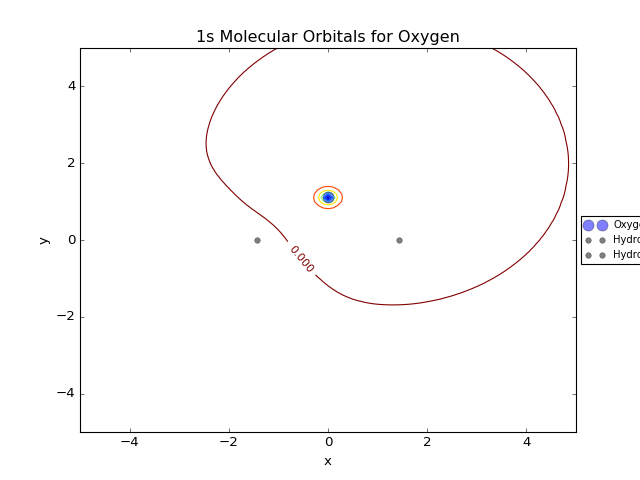

<IPython.core.display.Javascript object>


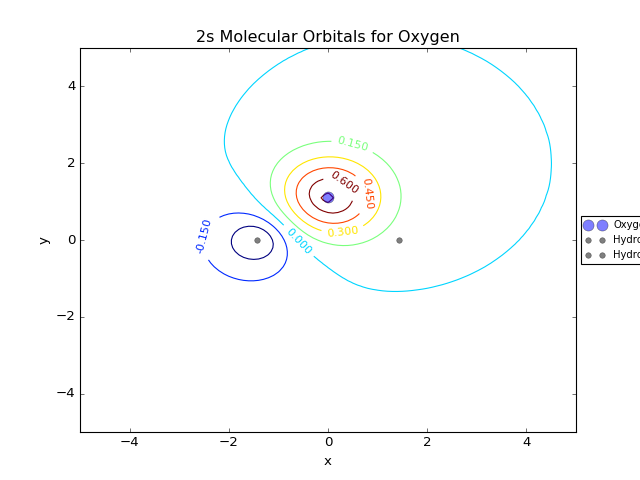

<IPython.core.display.Javascript object>


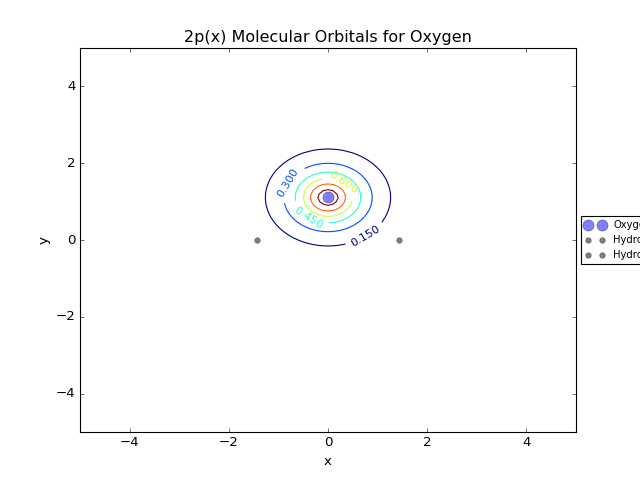

<IPython.core.display.Javascript object>


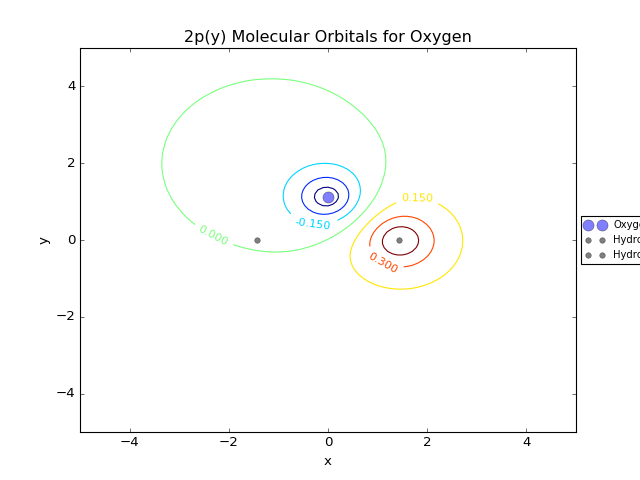

<IPython.core.display.Javascript object>


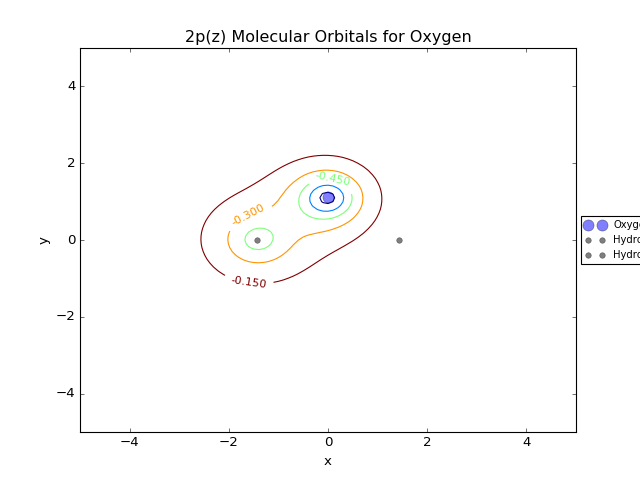

<IPython.core.display.Javascript object>


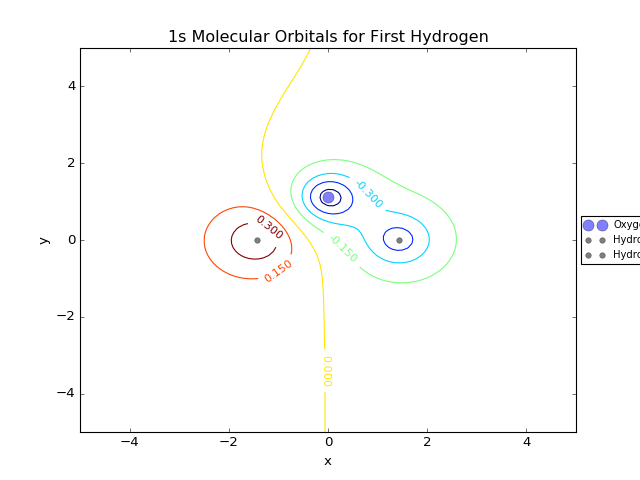

<IPython.core.display.Javascript object>


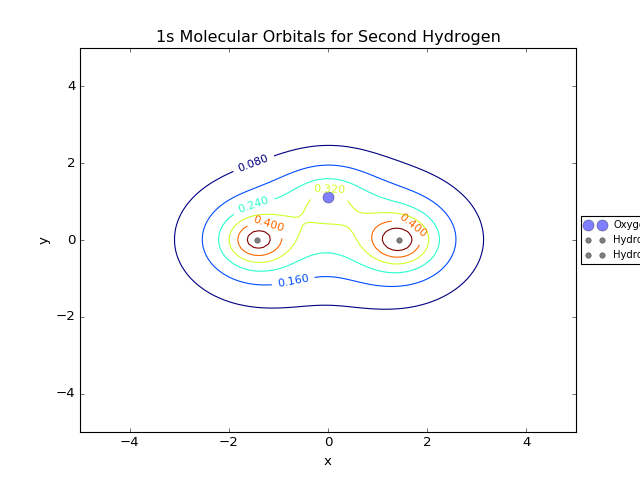

In [153]:
points = 100 # number of points in the grid
side = 5 # side length of the grid 
X = CHI_matrix(C, side, points) # calculate the orbitals
x = y = numpy.linspace(-side, side, points+1) # get the x & y axis

# list of titles for the plots
labels = ['1s Molecular Orbitals for Oxygen', 
          '2s Molecular Orbitals for Oxygen', 
          '2p(x) Molecular Orbitals for Oxygen', 
          '2p(y) Molecular Orbitals for Oxygen',
          '2p(z) Molecular Orbitals for Oxygen', 
          '1s Molecular Orbitals for First Hydrogen', 
          '1s Molecular Orbitals for Second Hydrogen']

# plot the graphs 
for i in range(C.shape[0]):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    contoor = ax.contour(x, y, X[:,:,i])
    ax.plot(R_O[0],R_O[1],'bo',ms=10,lw=1,label='Oxygen',alpha=0.5)
    ax.plot(R_H1[0],R_H1[1],'ko',ms=5,lw=1,label='Hydrogen 1',alpha=0.5)
    ax.plot(R_H2[0],R_H2[1],'ko',ms=5,lw=1,label='Hydrogen 2',alpha=0.5)
    ax.clabel(contoor, inline=1, fontsize=10)
    ax.legend(fontsize=9,loc='center left',bbox_to_anchor=[1,0.5])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(labels[i])
    fig.savefig('./pt{}.png'.format(i))